# Testing Feature Reduction
In this test to improve our model, we are testing the number of features needed to optimize our model, ranging from 3 to 10.

## 1. Setting Up Our Model

In [1]:
# Importing libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load the dataset
df = pd.read_csv('combined_donor_info.csv')

In [3]:
# Create a copy of the original DataFrame for cleaning
df_copy = df.copy()

### Missing Values

In [4]:
# Fill missing values appropriately
for column in df_copy.columns:
    if df_copy[column].dtype == 'object':  # Categorical data
        # Fill missing values with mode for categorical data
        df_copy[column] = df_copy[column].fillna(df_copy[column].mode()[0])
    else:  # Numerical data
        # Fill missing values with median for numerical data
        df_copy[column] = df_copy[column].fillna(df_copy[column].median())

### Changing Types

In [5]:
# Handle numerical conversions for specific columns
conv_to_float = []
for col in df_copy.columns:
    if df_copy[col].dtype == 'object':
        conv_to_float.append(col)

In [6]:
exclude_cols = ['Maked Primary Campaign', 'Stage', 'Account Type', 'Billing Zip/Postal Code', 
                'Fiscal Period', 'Close Date']
conv_to_float = [col for col in conv_to_float if col not in exclude_cols]

for col in conv_to_float:
    # Replace '#DIV/0!' with NaN first
    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
    
    # Fill NaNs with the median of the column
    median_value = df_copy[col].median()
    df_copy[col] = df_copy[col].fillna(median_value)
    
    # Convert the column to float
    try:
        df_copy[col] = df_copy[col].astype(float)
        print(f"Column '{col}' successfully converted to float with median replacement.")
    except ValueError:
        print(f"Column '{col}' could not be converted to float.")

Column 'Minority %' successfully converted to float with median replacement.
Column 'Poor %' successfully converted to float with median replacement.
Column 'Poor Family %' successfully converted to float with median replacement.
Column 'Car or Van %' successfully converted to float with median replacement.
Column 'Public Transport %' successfully converted to float with median replacement.
Column 'Health Ins %' successfully converted to float with median replacement.
Column 'No Health Ins %' successfully converted to float with median replacement.
Column 'Unemployed %' successfully converted to float with median replacement.
Column 'Employed %' successfully converted to float with median replacement.
Column 'Armed Forces %' successfully converted to float with median replacement.
Column 'Not in Labor Force %' successfully converted to float with median replacement.
Column 'Under 10 %' successfully converted to float with median replacement.
Column 'Under 35 %' successfully converted t

### Scaling Features

In [7]:
# Scale numerical features
numerical_columns = ['Amount', 'Pop', 'Households', 'HH Income', 'Education Years']
scaler = StandardScaler()
df_copy[numerical_columns] = scaler.fit_transform(df_copy[numerical_columns])

### Feature Engineering

In [8]:
# Create large donation flag
threshold = df_copy['Amount'].quantile(0.95)
df_copy['large_donation_flag'] = (df_copy['Amount'] > threshold).astype(int)

In [9]:
# Process dates
df_copy['Close Date'] = pd.to_datetime(df_copy['Close Date'])
df_copy['Close Year'] = df_copy['Close Date'].dt.year
df_copy['Close Month'] = df_copy['Close Date'].dt.month
df_copy['Close DayOfWeek'] = df_copy['Close Date'].dt.dayofweek

Our Label

In [10]:
donor_counts = df_copy['Masked Account ID'].value_counts()
df_copy['repeat_donor'] = df_copy['Masked Account ID'].map(lambda x: 1 if donor_counts[x] > 1 else 0)

In [11]:
df_copy = df_copy.drop_duplicates(subset='Masked Account ID').reset_index(drop=True)

In [12]:
# Handle categorical variables
import category_encoders as ce

# Target encoding for high-cardinality columns
target_encoder = ce.TargetEncoder(cols=['Billing Zip/Postal Code'])
df_copy[['Billing Zip/Postal Code']] = target_encoder.fit_transform(
    df_copy[['Billing Zip/Postal Code']], 
    df_copy['Amount']
)

In [13]:
# One-hot encoding for categorical columns
df_copy = pd.get_dummies(df_copy, columns=['Account Type', 'Stage', 'Maked Primary Campaign'], 
                        drop_first=True)

### Feature Selection

In [14]:
# Initialize feature selector
estimator = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=estimator, n_features_to_select=10)

# Prepare features
X = df_copy.drop(columns=['Amount', 'Masked Account ID', 'repeat_donor', 'Close Date', 'Fiscal Period'])
y = df_copy['repeat_donor']

# Fit RFE
rfe.fit(X, y)

# Get selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Billing Zip/Postal Code', 'ZCTA', 'Year', 'Minority %',
       'Poor Family %', 'No Health Ins %', 'Unemployed %', 'Close Year',
       'Close Month', 'Close DayOfWeek'],
      dtype='object')


## 2. Testing Our New Model

In [15]:
# Prepare features and target
X_full = df_copy.drop(columns=['Amount', 'Masked Account ID', 'repeat_donor', 'Close Date', 'Fiscal Period'])
y = df_copy['repeat_donor']

# Initialize parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define results storage
results = []

# Loop through different values of n_features_to_select
for n_features in range(3, 11):
    print(f"\nTesting with {n_features} selected features...")
    
    # Initialize RFE
    estimator = RandomForestClassifier(random_state=42)
    rfe = RFE(estimator=estimator, n_features_to_select=n_features)
    
    # Fit RFE
    rfe.fit(X_full, y)
    
    # Get selected features
    selected_features = X_full.columns[rfe.support_]
    print("Selected Features:", selected_features.tolist())
    
    # Prepare feature set
    X = df_copy[selected_features]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize and train model
    rf_model = RandomForestClassifier(random_state=42)
    rf_search = RandomizedSearchCV(
        estimator=rf_model, param_distributions=param_grid_rf, n_iter=20, 
        cv=5, scoring='f1', random_state=42, n_jobs=-1
    )
    rf_search.fit(X_train, y_train)
    
    # Make predictions
    best_rf_model = rf_search.best_estimator_
    y_pred = best_rf_model.predict(X_test)
    y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]
    
    # Evaluate model
    f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    print(f"F1 Score: {f1}")
    print(f"AUC-ROC: {auc_roc}")
    
    # Save results
    results.append({
        'n_features': n_features,
        'selected_features': selected_features.tolist(),
        'f1_score': f1,
        'auc_roc': auc_roc,
        'best_params': rf_search.best_params_
    })

# Find the optimal number of features
optimal_result = max(results, key=lambda x: x['f1_score'])
print("\nOptimal Result:")
print(optimal_result)


Testing with 3 selected features...
Selected Features: ['Billing Zip/Postal Code', 'Year', 'Minority %']
F1 Score: 0.810574607360849
AUC-ROC: 0.8761116468445301

Testing with 4 selected features...
Selected Features: ['Billing Zip/Postal Code', 'Year', 'Minority %', 'Poor Family %']
F1 Score: 0.8106734898638028
AUC-ROC: 0.874303546555234

Testing with 5 selected features...
Selected Features: ['Billing Zip/Postal Code', 'ZCTA', 'Year', 'Minority %', 'Poor Family %']
F1 Score: 0.8079123770300316
AUC-ROC: 0.8752946533804777

Testing with 6 selected features...
Selected Features: ['Billing Zip/Postal Code', 'ZCTA', 'Year', 'Minority %', 'Poor Family %', 'Close Year']
F1 Score: 0.7979337992134099
AUC-ROC: 0.8789778206364514

Testing with 7 selected features...
Selected Features: ['Billing Zip/Postal Code', 'ZCTA', 'Year', 'Minority %', 'Poor Family %', 'Close Year', 'Close Month']
F1 Score: 0.7875017662004064
AUC-ROC: 0.8767411336119147

Testing with 8 selected features...
Selected Featur

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare final feature set based on optimal result
selected_features = ['Billing Zip/Postal Code', 'Year', 'Minority %', 'Poor Family %']
X = df_copy[selected_features]
y = df_copy['repeat_donor']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the final model with optimal hyperparameters
best_params = {
    'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_depth': None,
    'bootstrap': False,
    'random_state': 42
}
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Evaluate model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.84      0.77       153
           1       0.89      0.79      0.84       244

    accuracy                           0.81       397
   macro avg       0.80      0.81      0.80       397
weighted avg       0.82      0.81      0.81       397

AUC-ROC: 0.874303546555234


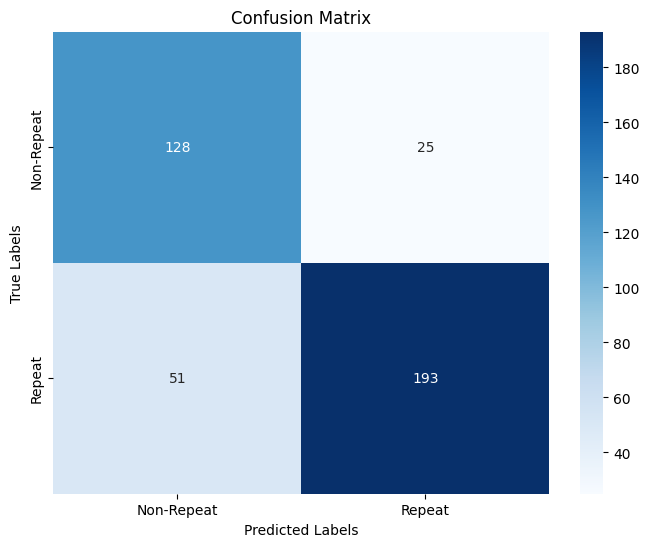

In [17]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Non-Repeat", "Repeat"], 
            yticklabels=["Non-Repeat", "Repeat"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

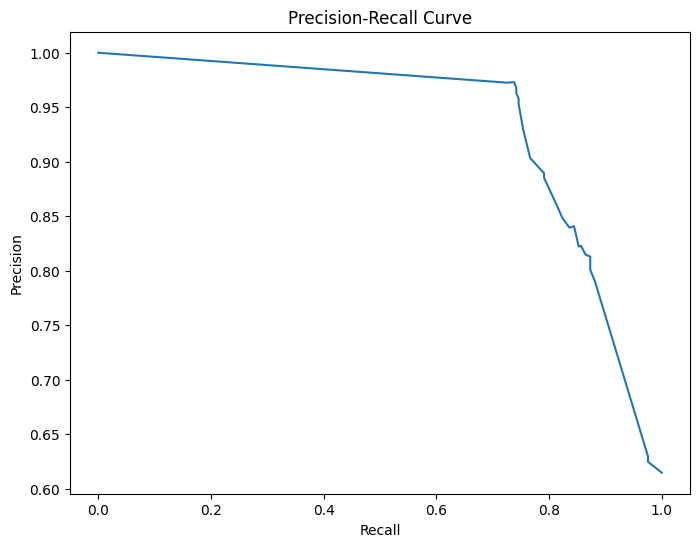

In [18]:
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

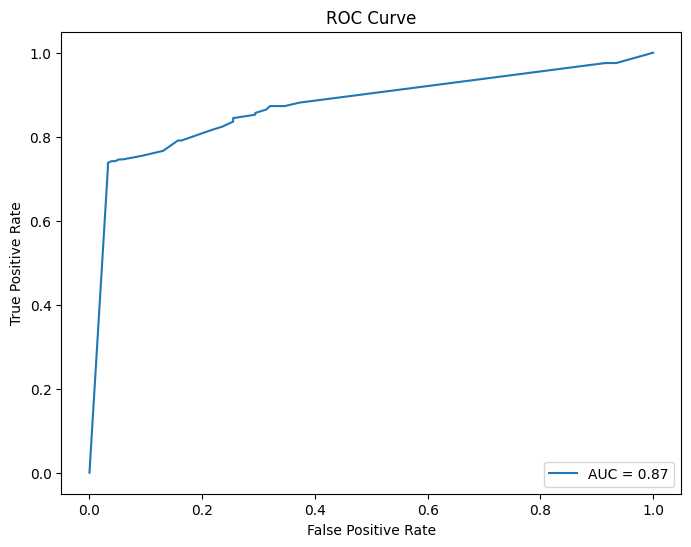

In [19]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Conclusion

Our current model had a higher AUC-ROC score by 0.1, so we will stick with our current model.

Interestingly, this model outputted that the best number of features were when there are only 4, but with 10 features the score is slightly better.